In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import os
import swifter

In [2]:
df = pd.read_csv('fashion-product-images-small/styles.csv', 
                 error_bad_lines=False, 
                 nrows=2000)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [3]:
BASE_IMG_DIR = 'fashion-product-images-small/images/'
df['image'] = df.apply(lambda x: os.path.join(BASE_IMG_DIR, str(x['id'])) + '.jpg', axis=1)
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,fashion-product-images-small/images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,fashion-product-images-small/images/39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,fashion-product-images-small/images/59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,fashion-product-images-small/images/21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,fashion-product-images-small/images/53759.jpg


In [86]:
def load_img(img):
    return cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)

In [5]:
img_width, img_height, _ = load_img(df.iloc[0].image).shape


base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(img_width, img_height, 3))

base_model.trainable = False
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPool2D()
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
def get_embeddings(model, img):
    try:
        img = tf.keras.preprocessing.image.load_img(img, target_size=(img_width, img_height))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = tf.keras.applications.resnet50.preprocess_input(x)

        return model.predict(x).reshape(-1)
    
    except Exception as e:
        print(e)
        return np.zeros((2048, ))

In [7]:
emb = get_embeddings(model, df.iloc[0].image)
emb.shape, emb

((2048,), array([0.       , 3.539247 , 0.       , ..., 4.4080763, 0.9500421,
        1.8472042], dtype=float32))

In [8]:
map_embeddings = df['image'].swifter.apply(lambda x: get_embeddings(model, x))
df_embeddings = map_embeddings.apply(pd.Series)

df_embeddings.head()

C:\Users\yasho\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,3.539247,0.000000,1.094606,0.000000,0.000000,4.458526,2.446010,2.678127,0.0,...,0.424309,0.000000,0.000000,5.880396,0.000000,0.000000,6.428888,4.408076,0.950042,1.847204
1,1.879341,1.600888,0.092036,4.433070,0.000000,0.000000,3.030766,8.530595,5.498664,0.0,...,2.808289,0.000000,3.923501,3.183100,0.000000,0.000000,4.244197,3.268900,2.271742,5.433379
2,0.000000,0.311198,0.000000,3.808685,0.437037,7.112502,0.000000,0.000000,0.000000,0.0,...,0.218201,7.861297,1.655926,0.000000,0.000000,0.000000,4.702997,0.000000,2.340579,0.000000
3,0.588025,9.894603,0.000000,6.295316,1.783723,1.913129,0.000000,13.309920,7.805777,0.0,...,22.434393,0.000000,0.000000,0.000000,2.565922,3.330487,0.594366,1.130462,3.084225,7.608913
4,0.000000,1.882978,0.000000,5.122102,0.000000,0.000000,2.950294,6.626860,1.606630,0.0,...,2.504941,0.000000,1.274127,3.484572,0.786348,0.000000,1.597853,2.515501,0.068349,0.000000


In [12]:
from sklearn.metrics.pairwise import pairwise_distances

In [10]:
cosine_similarity = 1 - pairwise_distances(df_embeddings, metric='cosine')
cosine_similarity[:10, :10]

array([[0.9999993 , 0.5813054 , 0.23863792, 0.49294096, 0.7768737 ,
        0.78373   , 0.7264087 , 0.6827244 , 0.2592094 , 0.34109336],
       [0.5813054 , 0.99999964, 0.23951352, 0.72273546, 0.5591109 ,
        0.5607198 , 0.5276978 , 0.61630493, 0.30997866, 0.31653053],
       [0.23863792, 0.23951352, 0.99999994, 0.2201165 , 0.22532964,
        0.24776673, 0.24512064, 0.22141808, 0.23761469, 0.32961702],
       [0.49294096, 0.72273546, 0.2201165 , 1.        , 0.47269428,
        0.5093883 , 0.4592421 , 0.47597313, 0.28999627, 0.2952199 ],
       [0.7768737 , 0.5591109 , 0.22532964, 0.47269428, 0.9999999 ,
        0.8535344 , 0.78745615, 0.71174324, 0.24678862, 0.2827196 ],
       [0.78373   , 0.5607198 , 0.24776673, 0.5093883 , 0.8535344 ,
        1.        , 0.742588  , 0.7025128 , 0.24169886, 0.3352905 ],
       [0.7264087 , 0.5276978 , 0.24512064, 0.4592421 , 0.78745615,
        0.742588  , 1.        , 0.7435711 , 0.19272596, 0.24565107],
       [0.6827244 , 0.61630493, 0.2214180

In [13]:
indices = pd.Series(range(len(df)), index=df.index)
indices.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [73]:
cosine_similarity[1805], cosine_similarity[1]

(array([0.35191888, 0.32988274, 0.4335096 , ..., 0.38833982, 0.4033711 ,
        0.28996462], dtype=float32),
 array([0.5813054 , 0.99999964, 0.23951352, ..., 0.5218955 , 0.28375852,
        0.84183705], dtype=float32))

In [74]:
def get_recommendations(idx, df, topn=6):
    
    sim_idx = indices[idx]
    print('Sim Idx: ', sim_idx)
    sim_scores = list(enumerate(cosine_similarity[sim_idx]))
#     print('Sim scores: ', sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     print('Sim Scores sorted: ', sim_scores)
    sim_scores = sim_scores[1:topn+1]
    print(sim_scores)
    
    idx_rec = [i[0] for i in sim_scores]
    idx_sim = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

In [75]:
import matplotlib.pyplot as plt
import random

In [91]:
ref = random.randint(1, len(indices))
ref

1083

In [92]:
get_recommendations(ref, df)

Sim Idx:  1083
[(1495, 0.9029952), (1865, 0.8730134), (62, 0.8545367), (704, 0.84644705), (1226, 0.84183794), (1137, 0.8301826)]


(Int64Index([1495, 1865, 62, 704, 1226, 1137], dtype='int64'),
 [0.9029952, 0.8730134, 0.8545367, 0.84644705, 0.84183794, 0.8301826])

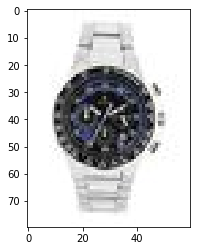

In [93]:
plt.imshow(load_img(df.iloc[ref].image))

In [94]:
idx_rec, idx_sim = get_recommendations(ref, df)

Sim Idx:  1083
[(1495, 0.9029952), (1865, 0.8730134), (62, 0.8545367), (704, 0.84644705), (1226, 0.84183794), (1137, 0.8301826)]


In [99]:
def run(ref, df):
    print('Reference ', ref)
    idx_rec, idx_sim = get_recommendations(ref, df)
    plt.figure(figsize=(4, 4))
    plt.imshow(load_img(df.iloc[ref].image))
    plt.title('Input image')
    plt.show()
    
    plt.figure(figsize=(10, 10))
    for i, id in enumerate(idx_rec):
        plt.subplot(2, 3, i+1)
        plt.imshow(load_img(df.iloc[id].image))
        plt.title('Silimar Recommendation {}'.format(i+1))
    plt.tight_layout()
    plt.show()

Reference  177
Sim Idx:  177
[(734, 0.9196274), (935, 0.8895539), (529, 0.861836), (1352, 0.84652954), (266, 0.84438), (824, 0.84404975)]


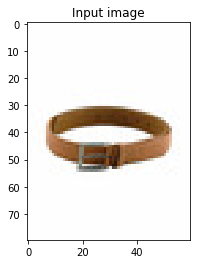

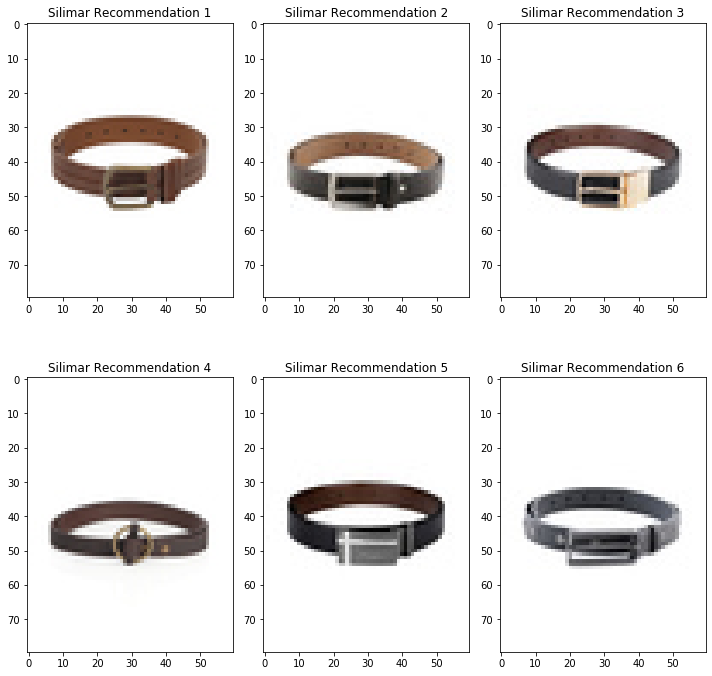

In [102]:
run(random.randint(1, len(indices)), df)

Reference  1380
Sim Idx:  1380
[(834, 0.8612485), (549, 0.85191166), (162, 0.76670814), (757, 0.7590666), (1308, 0.75672925), (1373, 0.7397468)]


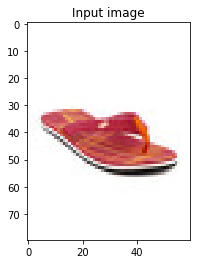

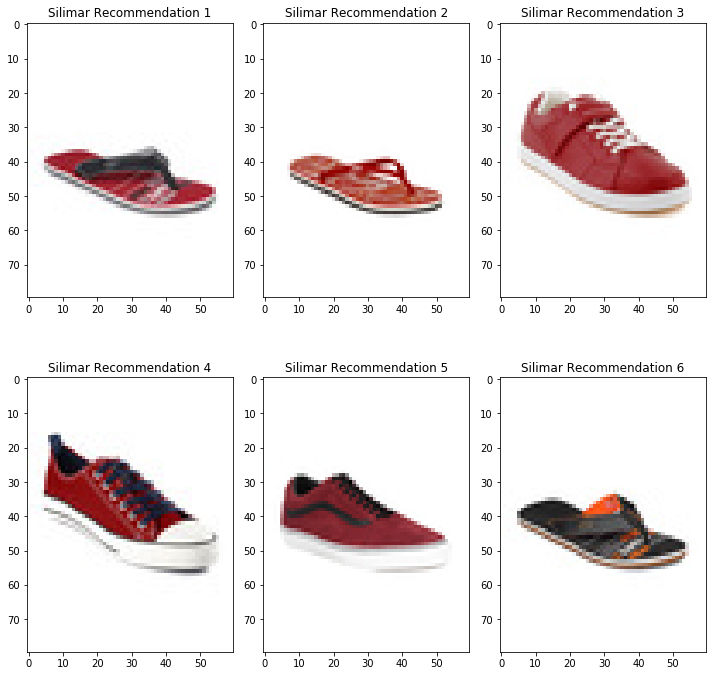

In [103]:
run(random.randint(1, len(indices)), df)

Reference  674
Sim Idx:  674
[(1344, 0.8840815), (342, 0.86881685), (253, 0.8680804), (269, 0.8594003), (306, 0.8536044), (1374, 0.8528583)]


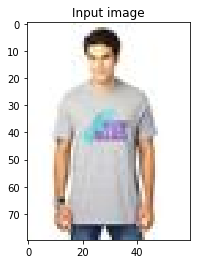

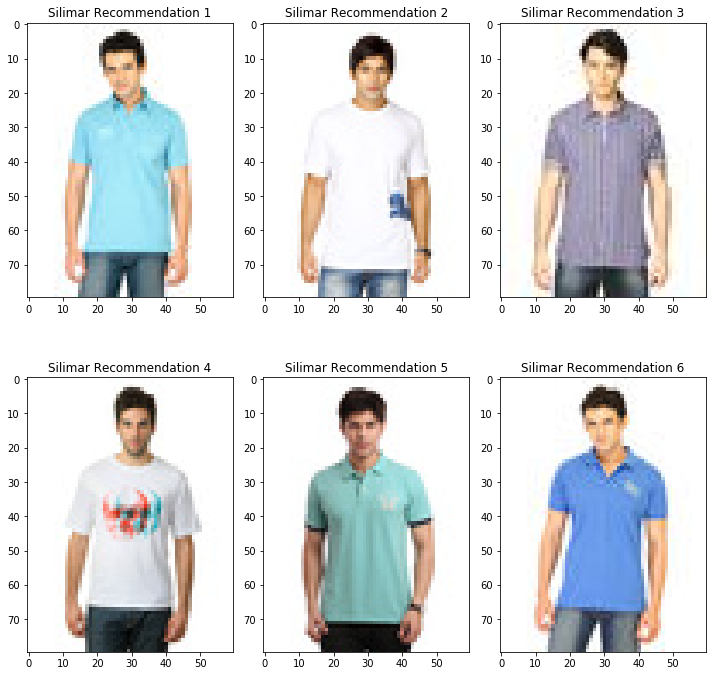

In [104]:
run(random.randint(1, len(indices)), df)

Reference  531
Sim Idx:  531
[(139, 0.8548879), (1963, 0.8390268), (1037, 0.8324522), (269, 0.83116454), (694, 0.8292899), (1234, 0.82667494)]


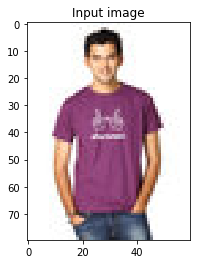

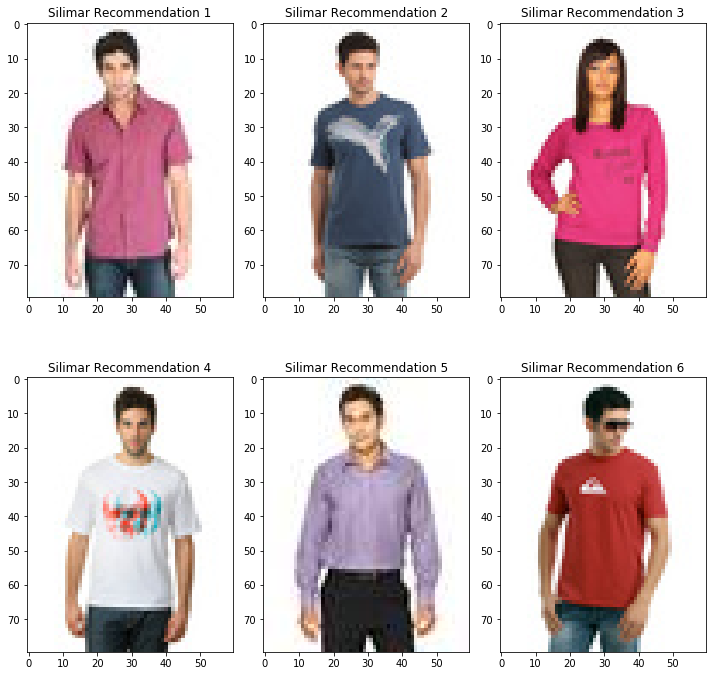

In [105]:
run(random.randint(1, len(indices)), df)

Reference  629
Sim Idx:  629
[(24, 0.93468744), (1721, 0.8757036), (1805, 0.8506962), (1523, 0.8249924), (1537, 0.82394665), (384, 0.820396)]


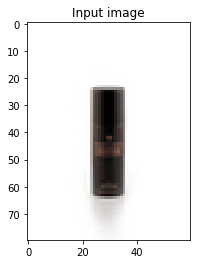

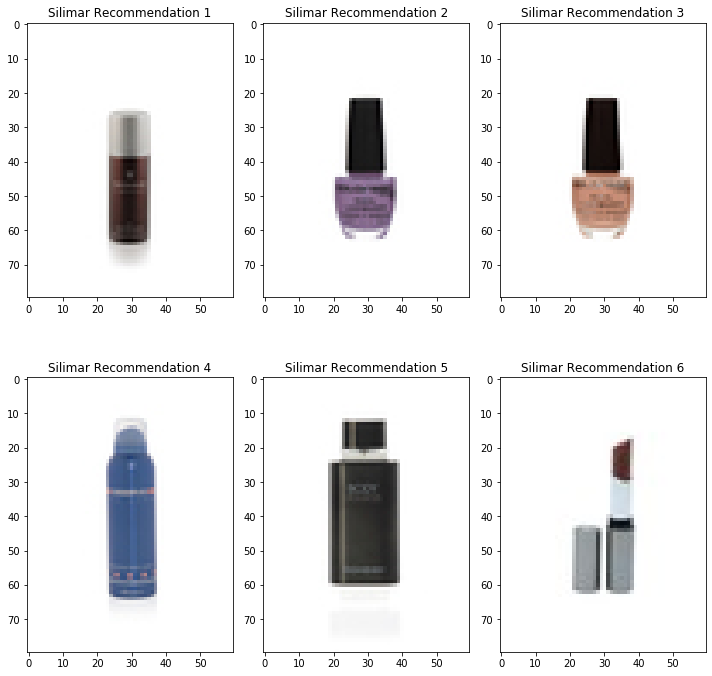

In [108]:
run(random.randint(1, len(indices)), df)